Feature analysis


In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()
file_name = next(iter(uploaded))
df_raw = pd.read_excel(file_name, header=None)

column_string = df_raw.iloc[0, 0]
columns = [col.strip().strip('"') for col in column_string.split(';')]

data = df_raw.iloc[1:, 0].str.split(';', expand=True)
data.columns = columns

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.columns = data.columns.str.strip().str.lower()
data.head()


Saving combined_wine_dataset.xlsx to combined_wine_dataset.xlsx


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,ph,sulphates,alcohol,quality
1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


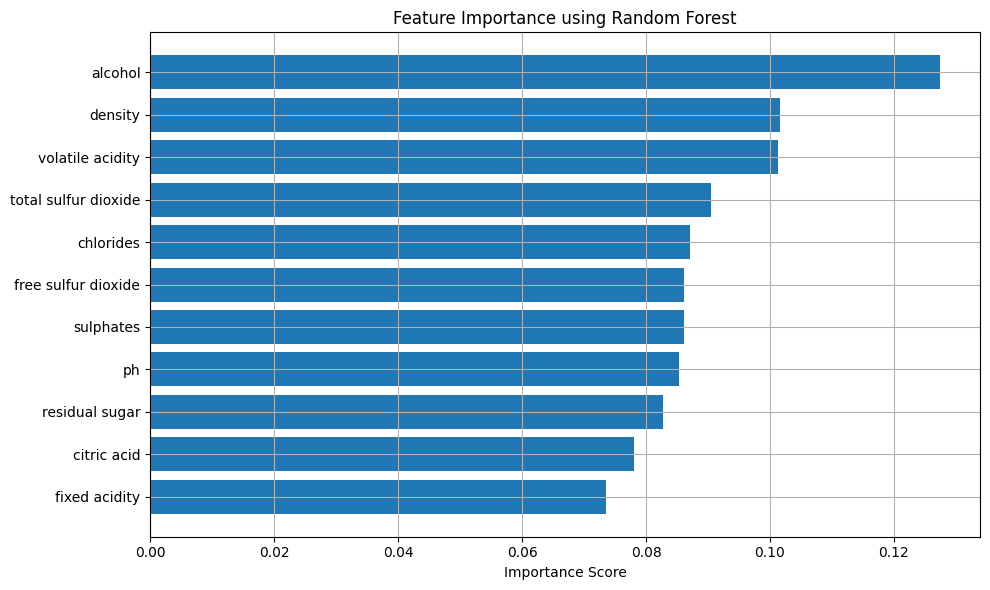

                 Feature  Importance
10               alcohol    0.127505
7                density    0.101572
1       volatile acidity    0.101315
6   total sulfur dioxide    0.090510
4              chlorides    0.087159
5    free sulfur dioxide    0.086192
9              sulphates    0.086121
8                     ph    0.085332
3         residual sugar    0.082760
2            citric acid    0.077995
0          fixed acidity    0.073540


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Prepare features and target
X = data.drop(columns=["quality"])
y = data["quality"]

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Feature Importance using Random Forest")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display feature importances
print(feature_importance_df)



In [ ]:
# Count the number of instances in each 'quality' label
quality_distribution = data["quality"].value_counts().sort_index()

# Display the distribution
quality_distribution


,count
quality,
3,30
4,216
5,2138
6,2836
7,1079
8,193
9,5


In [ ]:
!pip install imbalanced-learn


smote and borderlineSMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: Merge rare classes (3 → 4, 9 → 8)
data_merged = data.copy()
data_merged["quality"] = data_merged["quality"].replace({3: 4, 9: 8})

# Step 2: Split data
X = data_merged.drop(columns=["quality"])
y = data_merged["quality"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

custom_strategy = {
    4: 500,
    5: 2138,  # already sufficient, no change
    6: 2836,  # reduce from 2836
    7: 1000,
    8: 500
}

# Step 3: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Apply BorderlineSMOTE
border_smote = BorderlineSMOTE(sampling_strategy=custom_strategy, random_state=42, k_neighbors=2)
X_train_resampled, y_train_resampled = border_smote.fit_resample(X_train_scaled, y_train)

# Count the number of instances in each class after BorderlineSMOTE
final_class_distribution = pd.Series(y_train_resampled).value_counts().sort_index()
final_class_distribution

,count
quality,
4,500
5,2138
6,2836
7,1000
8,500


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

print("Training data size:", len(y_train_resampled))
print("Class distribution in training set:\n", pd.Series(y_train_resampled).value_counts())

# Step 5: Train Random Forest
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train_resampled, y_train_resampled)

# Step 6: Evaluate the model
y_pred = clf.predict(X_test_scaled)
report = classification_report(y_test, y_pred, output_dict=False)

print("\nClassification Report:\n", report)


Training data size: 6974
Class distribution in training set:
 quality
6    2836
5    2138
7    1000
4     500
8     500
Name: count, dtype: int64

Classification Report:
               precision    recall  f1-score   support

           4       0.41      0.18      0.25        49
           5       0.71      0.69      0.70       428
           6       0.66      0.78      0.71       567
           7       0.72      0.55      0.62       216
           8       0.76      0.55      0.64        40

    accuracy                           0.68      1300
   macro avg       0.65      0.55      0.59      1300
weighted avg       0.68      0.68      0.67      1300



SVM (all 4 kernals)

Training data size: 6974
Class distribution in training set:
 quality
6    2836
5    2138
7    1000
4     500
8     500
Name: count, dtype: int64

=== SVM Kernel: LINEAR ===
              precision    recall  f1-score   support

           4       0.00      0.00      0.00        49
           5       0.59      0.54      0.56       428
           6       0.49      0.78      0.60       567
           7       0.00      0.00      0.00       216
           8       0.00      0.00      0.00        40

    accuracy                           0.52      1300
   macro avg       0.22      0.26      0.23      1300
weighted avg       0.41      0.52      0.45      1300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== SVM Kernel: POLY ===
              precision    recall  f1-score   support

           4       0.32      0.14      0.20        49
           5       0.64      0.43      0.52       428
           6       0.51      0.83      0.63       567
           7       0.58      0.10      0.17       216
           8       0.26      0.15      0.19        40

    accuracy                           0.53      1300
   macro avg       0.46      0.33      0.34      1300
weighted avg       0.55      0.53      0.49      1300


=== SVM Kernel: RBF ===
              precision    recall  f1-score   support

           4       0.30      0.12      0.17        49
           5       0.64      0.59      0.61       428
           6       0.54      0.77      0.64       567
           7       0.68      0.18      0.29       216
           8       0.24      0.17      0.20        40

    accuracy                           0.57      1300
   macro avg       0.48      0.37      0.38      1300
weighted avg       0.58   

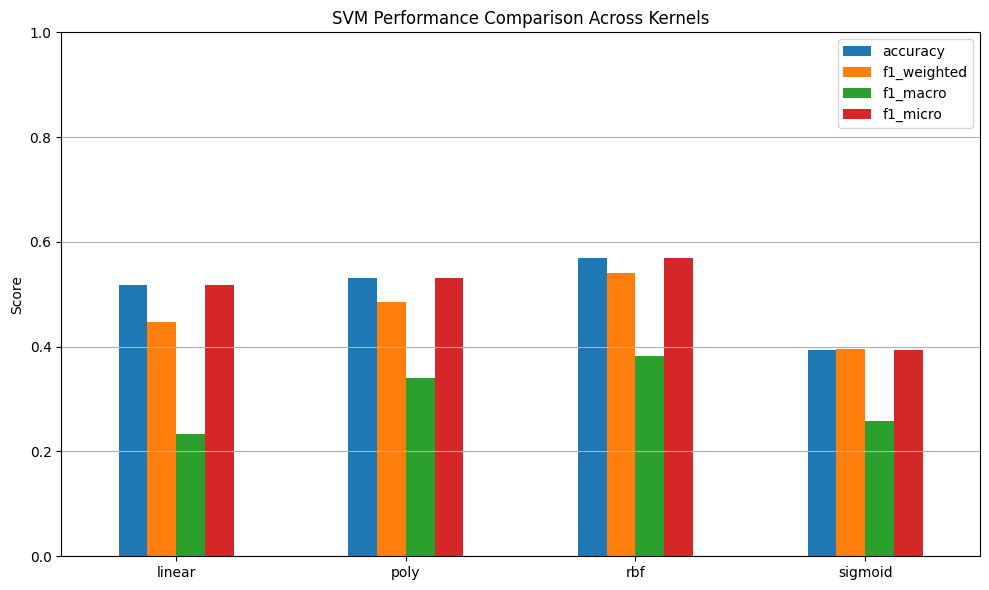

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

print("Training data size:", len(y_train_resampled))
print("Class distribution in training set:\n", pd.Series(y_train_resampled).value_counts())

# Train and evaluate SVMs using all four kernel types
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_results = {}

for kernel in kernels:
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)

    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')

    svm_results[kernel] = {
        'accuracy': acc,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro
    }

    print(f"\n=== SVM Kernel: {kernel.upper()} ===")
    print(classification_report(y_test, y_pred))

# Create DataFrame for metrics
svm_df = pd.DataFrame(svm_results).T

# Plot performance metrics
svm_df.plot(kind='bar', figsize=(10, 6))
plt.title("SVM Performance Comparison Across Kernels")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

print("Training data size:", len(y_train_resampled))
print("Class distribution in training set:\n", pd.Series(y_train_resampled).value_counts())

# Train Logistic Regression on the resampled training data
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred_logreg = log_reg.predict(X_test_scaled)

# Generate classification report
logreg_report = classification_report(y_test, y_pred_logreg)

# Output results
print("Logistic Regression Classification Report:\n", logreg_report)


Training data size: 6974
Class distribution in training set:
 quality
6    2836
5    2138
7    1000
4     500
8     500
Name: count, dtype: int64
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           4       0.31      0.08      0.13        49
           5       0.59      0.52      0.55       428
           6       0.51      0.73      0.60       567
           7       0.57      0.17      0.26       216
           8       0.11      0.10      0.10        40

    accuracy                           0.52      1300
   macro avg       0.42      0.32      0.33      1300
weighted avg       0.53      0.52      0.50      1300



In [ ]:
!pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=2b84398906305f3a6f9143299b5ddbb0adbd292e72e64a780e52801d753f568e
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


ordinal logistic regression

In [ ]:
# Import ordinal logistic regression from mord
from mord import LogisticIT
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

print("Training data size:", len(y_train_resampled))
print("Class distribution in training set:\n", pd.Series(y_train_resampled).value_counts())

# Encode the target labels to ordinal integers (0 to 4 for classes 4–8)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_resampled)
y_test_encoded = le.transform(y_test)

# Train Ordinal Logistic Regression (LogisticIT) on the encoded training data
ordinal_logistic_model = LogisticIT()
ordinal_logistic_model.fit(X_train_resampled, y_train_encoded)

# Predict on the test data
y_pred_ordinal = ordinal_logistic_model.predict(X_test_scaled)

# Generate classification report using encoded labels
ordinal_report = classification_report(y_test_encoded, y_pred_ordinal, target_names=le.classes_.astype(str))

# Output results
print("Ordinal Logistic Regression (LogisticIT) Classification Report:\n", ordinal_report)

# Optional: print overall metrics
print("\nAccuracy:", accuracy_score(y_test_encoded, y_pred_ordinal))
print("F1 (weighted):", f1_score(y_test_encoded, y_pred_ordinal, average='weighted'))
print("F1 (macro):", f1_score(y_test_encoded, y_pred_ordinal, average='macro'))
print("F1 (micro):", f1_score(y_test_encoded, y_pred_ordinal, average='micro'))


Training data size: 6974
Class distribution in training set:
 quality
6    2836
5    2138
7    1000
4     500
8     500
Name: count, dtype: int64
Ordinal Logistic Regression (LogisticIT) Classification Report:
               precision    recall  f1-score   support

           4       0.38      0.06      0.11        49
           5       0.59      0.48      0.53       428
           6       0.50      0.78      0.61       567
           7       0.62      0.04      0.07       216
           8       0.14      0.15      0.15        40

    accuracy                           0.51      1300
   macro avg       0.45      0.30      0.29      1300
weighted avg       0.53      0.51      0.46      1300


Accuracy: 0.5138461538461538
F1 (weighted): 0.46168842246251574
F1 (macro): 0.2929202856223214
F1 (micro): 0.5138461538461538


SVR

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

print("Training data size:", len(y_train_resampled))
print("Class distribution in training set:\n", pd.Series(y_train_resampled).value_counts())

# Train SVR model (ordinal approximation)
ordinal_svm = SVR(kernel='rbf', C=1.0, gamma='scale')
ordinal_svm.fit(X_train_resampled, y_train_resampled)

# Predict and round
y_pred_continuous = ordinal_svm.predict(X_test_scaled)
y_pred_ordinal = np.clip(np.round(y_pred_continuous), y_train_resampled.min(), y_train_resampled.max()).astype(int)

# Evaluate
report = classification_report(y_test, y_pred_ordinal)
print("SVR + rounding Classification Report:\n", report)


Training data size: 6974
Class distribution in training set:
 quality
6    2836
5    2138
7    1000
4     500
8     500
Name: count, dtype: int64
SVR + rounding Classification Report:
               precision    recall  f1-score   support

           4       0.28      0.10      0.15        49
           5       0.64      0.65      0.65       428
           6       0.58      0.64      0.61       567
           7       0.47      0.46      0.46       216
           8       0.20      0.03      0.04        40

    accuracy                           0.57      1300
   macro avg       0.43      0.38      0.38      1300
weighted avg       0.56      0.57      0.56      1300



In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Display training set info
print("Training data size:", len(y_train_resampled))
print("Class distribution in training set:\n", pd.Series(y_train_resampled).value_counts())

# Encode labels for ordinal classification
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_resampled)
y_test_encoded = le.transform(y_test)

# Define Ordinal SVM class
class OrdinalSVM:
    def __init__(self):
        self.models = []
        self.classes_ = []

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for k in self.classes_[:-1]:  # For K-1 thresholds
            binary_y = (y > k).astype(int)
            model = LinearSVC(random_state=42)
            model.fit(X, binary_y)
            self.models.append(model)

    def predict(self, X):
        pred = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            pred[:, i] = model.decision_function(X)
        return np.sum(pred > 0, axis=1)

# Train and predict using custom ordinal SVM
ordinal_svm = OrdinalSVM()
ordinal_svm.fit(X_train_resampled, y_train_encoded)
y_pred_ordinal = ordinal_svm.predict(X_test_scaled)

# Compute performance metrics
accuracy = accuracy_score(y_test_encoded, y_pred_ordinal)
f1_weighted = f1_score(y_test_encoded, y_pred_ordinal, average='weighted')
f1_macro = f1_score(y_test_encoded, y_pred_ordinal, average='macro')
f1_micro = f1_score(y_test_encoded, y_pred_ordinal, average='micro')

# Print full report
print("\nCustom Ordinal SVM Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_ordinal, target_names=le.classes_.astype(str)))

# Summarize metrics
ordinal_metrics = pd.DataFrame({
    'OrdinalSVM': {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro
    }
}).T



Training data size: 6974
Class distribution in training set:
 quality
6    2836
5    2138
7    1000
4     500
8     500
Name: count, dtype: int64

Custom Ordinal SVM Classification Report:

              precision    recall  f1-score   support

           4       1.00      0.02      0.04        49
           5       0.59      0.53      0.56       428
           6       0.51      0.70      0.59       567
           7       0.48      0.31      0.38       216
           8       0.00      0.00      0.00        40

    accuracy                           0.53      1300
   macro avg       0.52      0.31      0.31      1300
weighted avg       0.53      0.53      0.50      1300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Plots

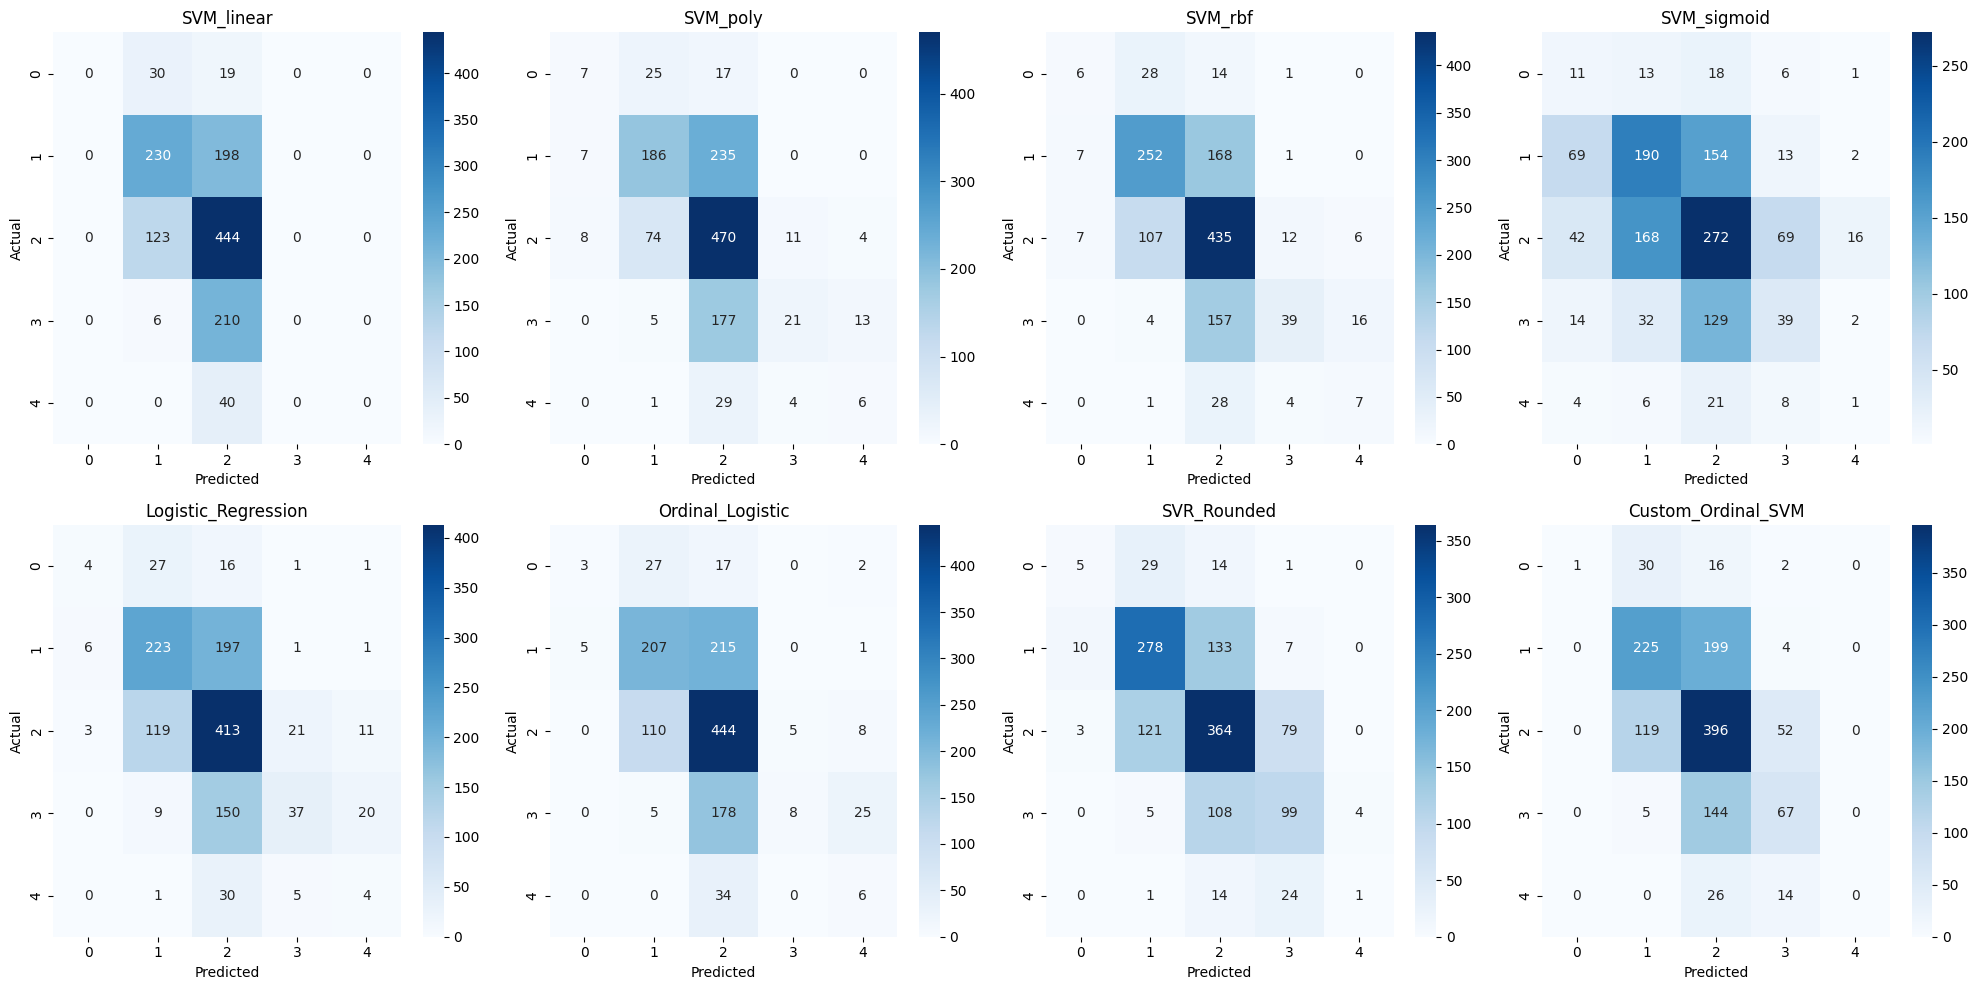

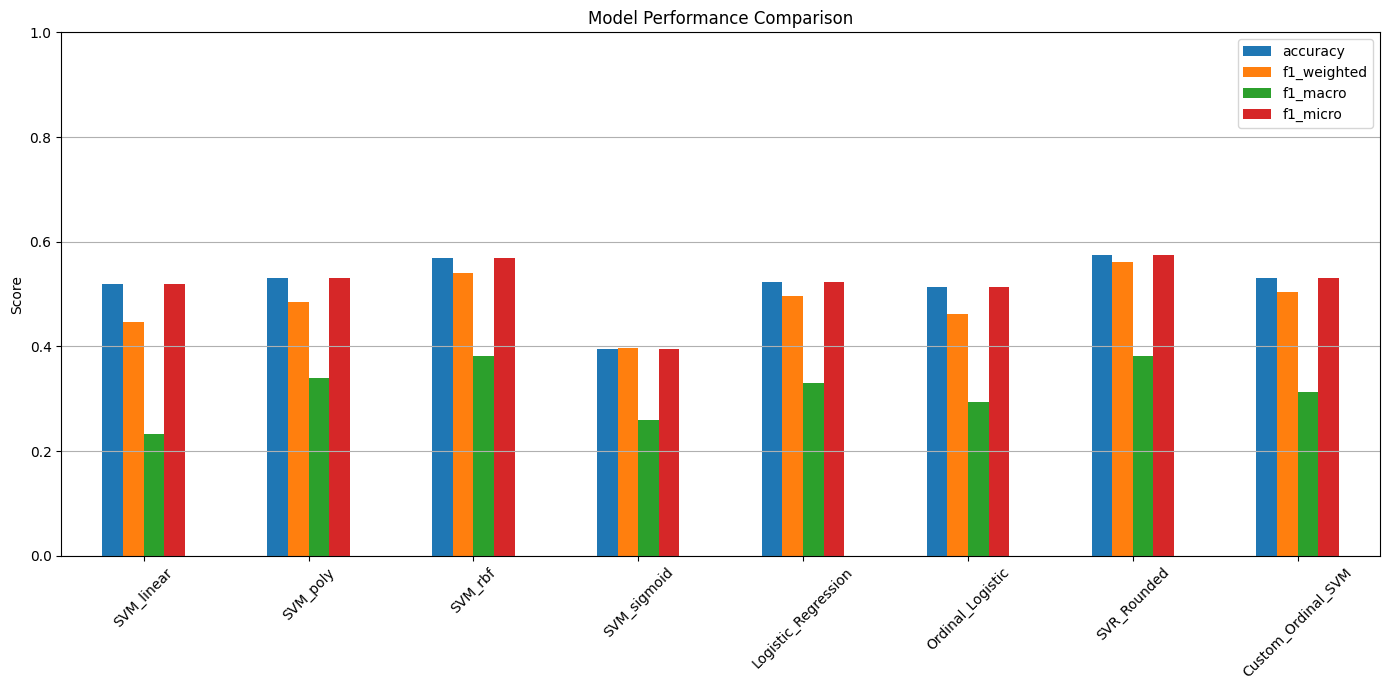

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary to store all predictions and model names
model_predictions = {
    "SVM_linear": SVC(kernel='linear', random_state=42).fit(X_train_resampled, y_train_resampled).predict(X_test_scaled),
    "SVM_poly": SVC(kernel='poly', random_state=42).fit(X_train_resampled, y_train_resampled).predict(X_test_scaled),
    "SVM_rbf": SVC(kernel='rbf', random_state=42).fit(X_train_resampled, y_train_resampled).predict(X_test_scaled),
    "SVM_sigmoid": SVC(kernel='sigmoid', random_state=42).fit(X_train_resampled, y_train_resampled).predict(X_test_scaled),
    "Logistic_Regression": LogisticRegression(max_iter=1000, random_state=42).fit(X_train_resampled, y_train_resampled).predict(X_test_scaled),
    "Ordinal_Logistic": ordinal_logistic_pred,
    "SVR_Rounded": np.clip(np.round(SVR(kernel='rbf', C=1.0, gamma='scale').fit(X_train_resampled, y_train_resampled).predict(X_test_scaled)),
                           y_train_resampled.min(), y_train_resampled.max()).astype(int),
}

# Custom Ordinal SVM
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_resampled)
y_test_encoded = le.transform(y_test)

class OrdinalSVM:
    def __init__(self):
        self.models = []
        self.classes_ = []

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for k in self.classes_[:-1]:
            binary_y = (y > k).astype(int)
            model = LinearSVC(random_state=42)
            model.fit(X, binary_y)
            self.models.append(model)

    def predict(self, X):
        pred = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            pred[:, i] = model.decision_function(X)
        return np.sum(pred > 0, axis=1)

custom_ordinal_model = OrdinalSVM()
custom_ordinal_model.fit(X_train_resampled, y_train_encoded)
model_predictions["Custom_Ordinal_SVM"] = custom_ordinal_model.predict(X_test_scaled)

# Compute confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, (name, y_pred) in enumerate(model_predictions.items()):
    cm = confusion_matrix(y_test if "Ordinal" not in name else y_test_encoded, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Compute and plot all performance metrics
metrics_data = {}

for name, y_pred in model_predictions.items():
    actual = y_test if "Ordinal" not in name else y_test_encoded
    metrics_data[name] = {
        "accuracy": accuracy_score(actual, y_pred),
        "f1_weighted": f1_score(actual, y_pred, average='weighted'),
        "f1_macro": f1_score(actual, y_pred, average='macro'),
        "f1_micro": f1_score(actual, y_pred, average='micro')
    }

metrics_df = pd.DataFrame(metrics_data).T
metrics_df.plot(kind='bar', figsize=(14, 7))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
